In [3346]:
import pandas as pd
import numpy as np
from torch import nn
from sklearn.preprocessing import PowerTransformer, StandardScaler
from torchviz import make_dot
from itertools import islice
import torch
import numpy
from sklearn.model_selection import train_test_split
import statistics as stats
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import hiddenlayer as hl
import graphviz
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

# Importing the data

In [3347]:
def to_list(str):
    '''
    :param str: string representing a list of centipawn losses
    :return: list of integer centipawn losses
    '''
    string = str.replace('[','').replace(']','')
    ls = string.split(',')
    list = [int(i) for i in ls]

    return list

In [3348]:
def black_process(evals):
    '''
    :param eval: list of integer centipawn losses
    :return: array of lists of [evaluation, centipawn loss]
    '''

    i = 0
    old_eval = 36
    res = []

    # iterating through centipawn losses
    for eval in evals:

        # subtracting the cpl for white's moves
        if i % 2 ==0:
            cpl = old_eval - eval
            res.append([old_eval,cpl])
            old_eval = eval
            i += 1

        # adding the cpl for black's moves
        else:
            old_eval = eval
            i+=1

    return numpy.array(res)

In [3349]:
def white_process(evals):
    '''
    :param eval: list of integer centipawn losses
    :return: array of lists of [evaluation, centipawn loss]
    '''

    i = 0
    old_eval = 36
    res = []

    # iterating through centipawn losses
    for eval in evals:

        # subtracting the cpl for white's moves
        if i % 2 ==1:
            cpl = old_eval - eval
            res.append([old_eval,cpl])
            old_eval = eval
            i += 1

        # adding the cpl for black's moves
        else:
            old_eval = eval
            i+=1

    return numpy.array(res)

In [3350]:
# reading *some* of the data
dfs = []

players = ['andreikin, dmitry', 'anand, viswanathan', 'wang, hao', 'grischuk, alexander', 'karjakin, sergey','duda, jan-krzysztof', 'radjabov, teimour', 'dominguez perez, leinier','nakamura, hikaru', 'vachier-lagrave, maxime','aronian, levon','mamedyarov, shakhriyar', 'so, wesley','ding, liren', 'rapport, richard', 'nepomniachtchi, ian', 'giri, anish', 'firouzja, alireza', 'caruana, fabiano','carlsen, magnus','zelcic, robert','khotenashvili, bela', 'bischoff, klaus', 'hoffmann, asa','kaufman, lawrence','bellaiche, elise']

# reading the csvs
for player in players:
    df = pd.read_csv('blitz/'+player +'.csv')
    dfs.append(df)
df = pd.concat(dfs)


print(f"Total  games: {len(df)}")

# Filtering out * values
df = df[df['WhiteELO'] != '*']
df = df[df['BlackELO'] != '*']
df[['WhiteELO', 'BlackELO']] = df[['WhiteELO', 'BlackELO']] .astype(int)

df = df[df['Eval'] != '']
df = df[ df['Eval'].apply(lambda x: isinstance(x, str))]


# converting the evaluation to a list
df['Eval'] = df['Eval'].apply( to_list)
df['WhiteEval'] = df.apply(lambda x : white_process(x.Eval), axis =1 )
df['BlackEval'] = df['Eval'].apply( black_process )

print(f"Evaluted games: {len(df['Eval'])}")

Total  games: 8164
Evaluted games: 927


In [3351]:
df_flipped = df.copy()
df_flipped['WhiteEval'] = df_flipped['BlackEval']
df_flipped['WhiteELO'] = df_flipped['BlackELO']

In [3352]:
df = pd.concat([df, df_flipped])

In [3353]:
print(f"Evaluted games: {len(df['Eval'])}")

Evaluted games: 1854


In [3354]:
#df = df[df['WhiteELO'] != 2185]

In [3355]:
#df = df[df['WhiteELO'] > 2450]

In [3356]:
white_x = numpy.array(df['WhiteEval'])
white_length = numpy.array(df['WhiteEval'].apply(len))

black_x = numpy.array(df['WhiteEval'])
black_length = numpy.array(df['WhiteEval'].apply(len))

In [3357]:
# creating and fitting a power transformer for black and white
wpt = PowerTransformer()
wpt = StandardScaler()
white_y = numpy.concatenate(white_x)
wpt.fit(white_y)
white_transformed = wpt.transform(white_y)

bpt = PowerTransformer()
black_y = numpy.concatenate(black_x)
bpt.fit(black_y)
black_transformed = bpt.transform(black_y)

In [3358]:
def avg_cpl(white_processed):
    '''
    get the average centipawn loss from an evaluated game
    :param white_processed: list of lists of the form [evaluation, centipawn loss]
    :return: average centipawn loss (float)
    '''
    cpls = []
    for i in white_processed:
        cpls.append(i[1])
    if len(cpls) == 0:
        return float('NaN')
    else:
        return stats.mean(cpls)

In [3359]:
df['White_avg_cpl'] = df['WhiteEval'].copy().apply( avg_cpl )

In [3360]:
df = df[df['Eval']!='']

<AxesSubplot:>

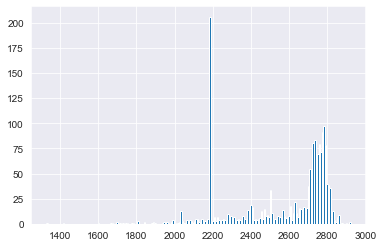

In [3361]:
df['WhiteELO'].hist(bins = 200)

<AxesSubplot:xlabel='WhiteELO', ylabel='[White_avg_cpl]'>

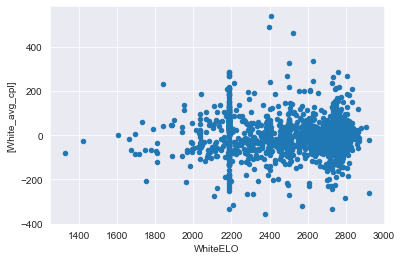

In [3362]:
df.plot.scatter(x='WhiteELO', y = ['White_avg_cpl'])

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='WhiteELO', ylabel='White_avg_cpl'>

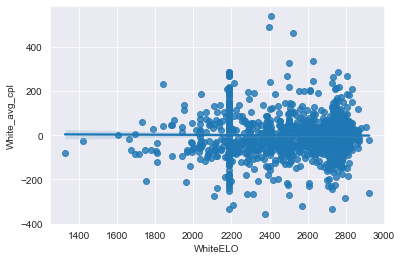

In [3363]:
plt.figure()
sns.regplot(df['WhiteELO'], df['White_avg_cpl'])

In [3364]:
# make a simple linear regression model.
X = np.array(df['White_avg_cpl'])
X = np.reshape(X, (len(X), 1))
y = np.array(df['WhiteELO'])
y = np.reshape(y, (len(y), 1))
regression = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

regression.fit(X_train,y_train)
regression.score(X_test,y_test)
#plt.scatter(y, pred_y)

y_pred = regression.predict(X_test)

In [3365]:
# need a function now to (effieciently) change these to lists of length list
white_transformed_array = [numpy.array(list(islice(iter(white_transformed), elem)))
        for elem in white_length]

black_transformed_array = [numpy.array(list(islice(iter(black_transformed), elem)))
        for elem in black_length]

In [3366]:
print(f"Unique evaluated games: {df['Game'].nunique()}")

Unique evaluated games: 898


# Preparing the data for the Neural Net

In [3367]:
# converting evaluations and length to tensors
white_evals = [torch.tensor(i, dtype = torch.float32) for i in white_transformed_array]
white_lengths = [len(tensor) for tensor in white_evals]

black_evals = [torch.tensor(i, dtype = torch.float32) for i in black_transformed_array]
black_lengths = [len(tensor) for tensor in black_evals]

In [3368]:
# Padding my sequences - not sure why batch first works, but it does
#inputs = torch.nn.utils.rnn.pad_sequence(evals, batch_first=True, padding_value=0.0)

In [3369]:
#inputs_array = numpy.array(inputs.tolist())

In [3370]:
#print(inputs.shape)

In [3371]:
#inputs_list =inputs.tolist()

# normalizing... a bit hacky
#inputs_array = (numpy.array(inputs_list) - numpy.array(inputs_list).mean())/ numpy.linalg.norm(numpy.array(inputs_list))

In [3372]:
#print(df['WhiteELO'].value_counts())

In [3373]:
white_elo_arr = numpy.array(df['WhiteELO'])

In [3374]:
#welopt = PowerTransformer(method = 'box-cox')
welopt = StandardScaler()
white_elo_arr = np.reshape(white_elo_arr, (len(white_elo_arr),1))
welopt.fit(white_elo_arr)
white_elo_transformed = welopt.transform(white_elo_arr)

(array([  1.,   1.,   0.,   1.,   5.,   6.,   6.,  10.,  27.,  30., 233.,
         52.,  57.,  91., 113.,  73., 133., 516., 476.,  23.]),
 array([-4.88043792, -4.56791343, -4.25538895, -3.94286446, -3.63033997,
        -3.31781549, -3.005291  , -2.69276651, -2.38024203, -2.06771754,
        -1.75519306, -1.44266857, -1.13014408, -0.8176196 , -0.50509511,
        -0.19257062,  0.11995386,  0.43247835,  0.74500284,  1.05752732,
         1.37005181]),
 <BarContainer object of 20 artists>)

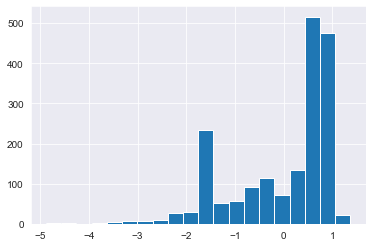

In [3375]:
plt.hist(white_elo_transformed, bins =20)

In [3376]:
# Converting White and Black's ELOs to tensors
white_elo = [torch.tensor(i, dtype = torch.float32) for i in white_elo_transformed]



black_elo = numpy.array(df['BlackELO'])
black_elo = [torch.tensor(i, dtype = torch.float32) for i in black_elo]

average_cpl = np.array(df['White_avg_cpl'])

# splitting into train and test
white_eval_train, white_eval_test, black_eval_train, black_eval_test, black_train, black_test, white_train, white_test, average_cpl_train, average_cpl_test  = train_test_split(white_evals, black_evals, black_elo, white_elo, average_cpl, test_size=0.15,random_state=100, shuffle = True)

## Baseline model

In [3377]:
average_cpl_train = np.reshape(average_cpl_train, (len(average_cpl_train),1))
average_cpl_test = np.reshape(average_cpl_test, (len(average_cpl_test),1))

In [3378]:
white_train_elo = np.array([x.item() for x in white_train])
white_train_elo = np.reshape(white_train_elo, (len(white_train_elo),1 ))
white_train_elo_transformed = welopt.inverse_transform(white_train_elo)

white_test_elo = np.array([x.item() for x in white_test])
white_test_elo = np.reshape(white_test_elo, (len(white_test_elo),1 ))
white_test_elo_transformed = welopt.inverse_transform(white_test_elo)

In [3379]:
# make a simple linear regression model.
regression = LinearRegression()


regression.fit(average_cpl_train,white_train_elo_transformed)
regression.score(average_cpl_test,white_test_elo)
#plt.scatter(y, pred_y)

y_pred = regression.predict(average_cpl_test)

In [3380]:
mse_lin = mean_squared_error(white_test_elo_transformed, y_pred)

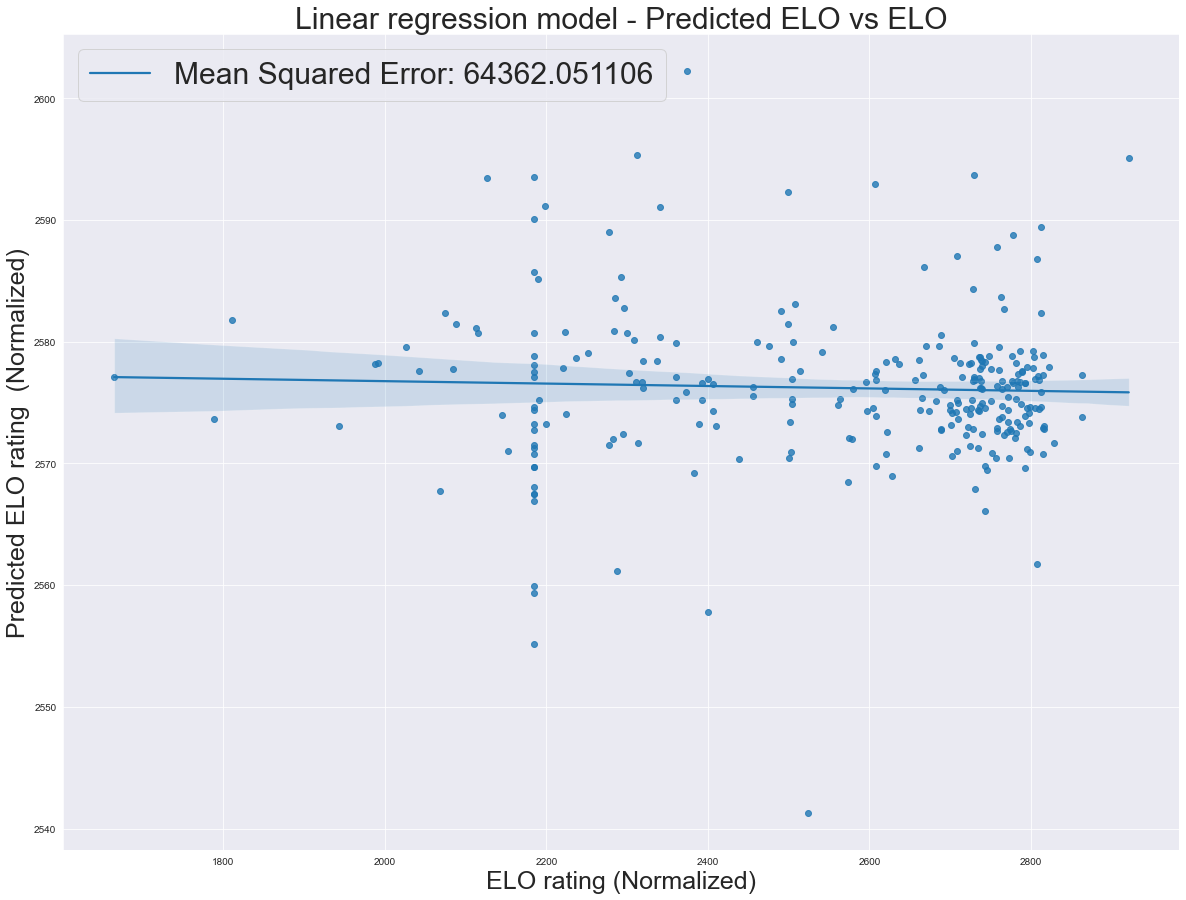

In [3381]:
plt.figure(figsize = (20,15))
plt.title('Linear regression model - Predicted ELO vs ELO', fontsize = 30)
sns.regplot(x = white_test_elo_transformed, y = y_pred, line_kws = {'label':f'Mean Squared Error: {mse_lin:4f}'})
plt.xlabel('ELO rating (Normalized)', fontsize = 25)
plt.ylabel('Predicted ELO rating  (Normalized)', fontsize = 25)
plt.legend(prop={'size': 30})
plt.savefig('images/NN_linreg_acc1.png')

(array([  2.,   1.,  11.,  16.,  57., 285., 148., 186., 649., 499.]),
 array([-4.88043792, -4.25538895, -3.63033997, -3.005291  , -2.38024203,
        -1.75519306, -1.13014408, -0.50509511,  0.11995386,  0.74500284,
         1.37005181]),
 <BarContainer object of 10 artists>)

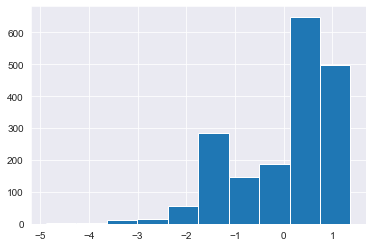

In [3382]:
plt.hist(white_elo_transformed)

In [3383]:
# zipping the elo together with the evaluations
# train_data_zip = list(zip(white_eval_train, black_eval_train, white_train))
# test_data_zip = list(zip(white_eval_test, black_eval_test, white_test))

train_data_zip = list(zip(white_eval_train, white_train))
test_data_zip = list(zip(white_eval_test, white_test))

In [3384]:
black_elo = torch.stack(black_elo)
white_elo = torch.stack(white_elo)

# Creating the Neural Net

In [3385]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, no_layers):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.no_layers = no_layers
        self.rnn = nn.RNN(input_size, hidden_size, no_layers, batch_first = True, bias = False)
        self.fc = nn.Linear(hidden_size,1, bias = False)
        self.final = nn.Tanh()

    def forward(self, x):

        out, _ = self.rnn(x)
        output ,lengths = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first = True)


        out = [output[e, i-1,:].unsqueeze(0)for e, i in enumerate(lengths)]
        out = torch.cat(out, dim = 0)


        out = self.fc(out)
        out = self.final(out)
        out = out[:,0]

        return out

In [3386]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, no_layers):
        super(MyLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.no_layers = no_layers
        self.lstm = nn.LSTM(input_size, hidden_size, no_layers, batch_first = True, bias = True, dropout = 0.25)
        self.fc = nn.Linear(hidden_size,1, bias = False)
        self.final = nn.Tanh()

    def forward(self, x):

        out, _ = self.lstm(x)
        output ,lengths = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first = True)


        out = [output[e, i-1,:].unsqueeze(0)for e, i in enumerate(lengths)]
        out = torch.cat(out, dim = 0)


        out = self.fc(out)
        out = self.final(out)
        out = out[:,0]

        return out

In [3387]:
class MyCollator(object):
    '''
    Yields a batch from a list of Items
    Args:
    test : Set True when using with test data loader. Defaults to False
    percentile : Trim sequences by this percentile
    '''

    # remove that eventually. I'm going to need to make my dataset a tuple with evals and elo
    #def __init__(self):

    def __call__(self, batch):
        white_data = [item[0] for item in batch]
        #black_data = [item[1] for item in batch]
        target = [item[1] for item in batch]
        white_lens = [i.shape[0] for i in white_data]
        #black_lens = [i.shape[0] for i in black_data]


        white_data = torch.nn.utils.rnn.pad_sequence(white_data, batch_first=True,padding_value = 0)
        white_evals_packed = torch.nn.utils.rnn.pack_padded_sequence(white_data,batch_first = True, lengths=white_lens,enforce_sorted=False)

        # black_data = torch.nn.utils.rnn.pad_sequence(black_data, batch_first=True,padding_value = 0)
        # black_evals_packed = torch.nn.utils.rnn.pack_padded_sequence(black_data,batch_first = True, lengths=black_lens,enforce_sorted=False)


        target = torch.tensor(target,dtype=torch.float32)
        return [white_evals_packed, target]

In [3388]:
input_size = 2
hidden_size = 26
no_layers = 2
batch_size = 7

In [3389]:
# (defining my model)
model = MyRNN(input_size, hidden_size, no_layers)
model = MyLSTM(input_size, hidden_size, no_layers)
collate = MyCollator()

In [3390]:
print(model.parameters)

<bound method Module.parameters of MyLSTM(
  (lstm): LSTM(2, 26, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=26, out_features=1, bias=False)
  (final): Tanh()
)>


# Training the model

In [3391]:
writer = SummaryWriter('runs/h45l4-2')

In [3392]:
data_loader = torch.utils.data.DataLoader(train_data_zip, batch_size=batch_size, shuffle=True ,collate_fn=collate)

In [3393]:
learning_rate = .1

In [3394]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3395]:
criterion = nn.MSELoss()
#criterion = nn.L1Loss()
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)

In [3396]:
avg_losses = []
epochs = []
avg_loss = 0.1

for epoch in range(16):

    if (epoch+1) % 3 == 0:
        learning_rate /= 2
        optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)

    losses = []

    i = 0
    for white_evals, elo in data_loader:
        white_evals = white_evals.to(device)
        #black_evals = black_evals.to(device)
        elo = elo.to(device)
        outputs = model(white_evals)
        #print(outputs)
        #print(outputs.shape, elo.shape)
        loss = criterion(outputs,elo)
        # optimizing
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        i+=1

    change = stats.mean(losses)/avg_loss
    avg_loss = stats.mean(losses)

    # adding histograms to the summary writer
    for name, param in model.named_parameters():
        writer.add_histogram(name, np.array(param.detach().tolist()), epoch)

    # adding loss
    writer.add_scalar('Average loss',avg_loss, epoch)
    avg_losses.append(avg_loss)
    epochs.append(epoch)
    print(f'Epoch {epoch+1} step {i+1} - Learning Rate : {learning_rate}- Avg Loss: {avg_loss:3f} - Change in loss: {change}')


writer.close()

Epoch 1 step 226 - Learning Rate : 0.1- Avg Loss: 1.052316 - Change in loss: 10.52315841946337
Epoch 2 step 226 - Learning Rate : 0.1- Avg Loss: 1.013238 - Change in loss: 0.9628650153264986
Epoch 3 step 226 - Learning Rate : 0.05- Avg Loss: 1.013932 - Change in loss: 1.000684403344406
Epoch 4 step 226 - Learning Rate : 0.05- Avg Loss: 1.007889 - Change in loss: 0.9940399715524237
Epoch 5 step 226 - Learning Rate : 0.05- Avg Loss: 1.007044 - Change in loss: 0.9991622500633425
Epoch 6 step 226 - Learning Rate : 0.025- Avg Loss: 1.009151 - Change in loss: 1.0020916266569737
Epoch 7 step 226 - Learning Rate : 0.025- Avg Loss: 1.005406 - Change in loss: 0.9962895225636685
Epoch 8 step 226 - Learning Rate : 0.025- Avg Loss: 1.004611 - Change in loss: 0.9992095505988962
Epoch 9 step 226 - Learning Rate : 0.0125- Avg Loss: 1.009423 - Change in loss: 1.004789921674748
Epoch 10 step 226 - Learning Rate : 0.0125- Avg Loss: 1.003805 - Change in loss: 0.9944343872622862
Epoch 11 step 226 - Learnin

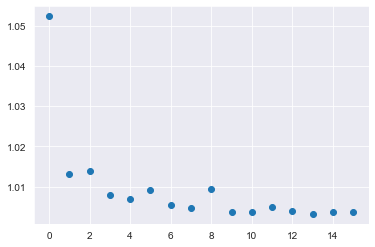

In [3397]:
plt.scatter(epochs, avg_losses)

## Test data

In [3398]:
model =model.eval()

In [3399]:
model.to(device)

MyLSTM(
  (lstm): LSTM(2, 26, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=26, out_features=1, bias=False)
  (final): Tanh()
)

In [3400]:
test_data_loader = torch.utils.data.DataLoader(test_data_zip, batch_size=1, shuffle=False ,collate_fn=collate)

In [3401]:
losses = []
outputs = []
elos = []
for evals, elo in test_data_loader:
    #print("evals",evals.shape)
    evals = evals.to(device)
    elo = elo.to(device)
    output = model(evals)
    outputs.append(output.item())
    elos.append(elo.item())
    loss = criterion(output,elo)
    #print(f'Model prediction : {output} \n ELO : {elo} \n MSE : {loss}')
    losses.append(loss.item())
print(f'Average loss : {stats.mean(losses)}')

Average loss : 0.9839150612040916


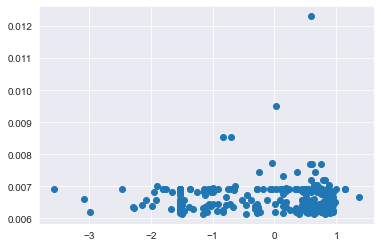

In [3402]:
plt.scatter(elos, outputs)

In [3403]:
elos = np.array(elos)
elos = np.reshape(elos, (len(elos),1))

outputs = np.array(outputs)
outputs = np.reshape(outputs, (len(outputs),1))

In [3404]:
print(elos[1], elos[2])
print(outputs[1], outputs[2])

[-0.90926212] [0.72385454]
[0.00692938] [0.00691918]


In [3405]:
elos = welopt.inverse_transform(elos)
outputs = welopt.inverse_transform(outputs)

In [3406]:
print(elos[1], elos[2])
print(outputs[1], outputs[2])

[2340.9999986] [2757.99999491]
[2574.94032852] [2574.93772611]


In [3407]:
mse_model = mean_squared_error(elos,outputs)

In [3408]:
# de-normalize the elos - predicted and actual

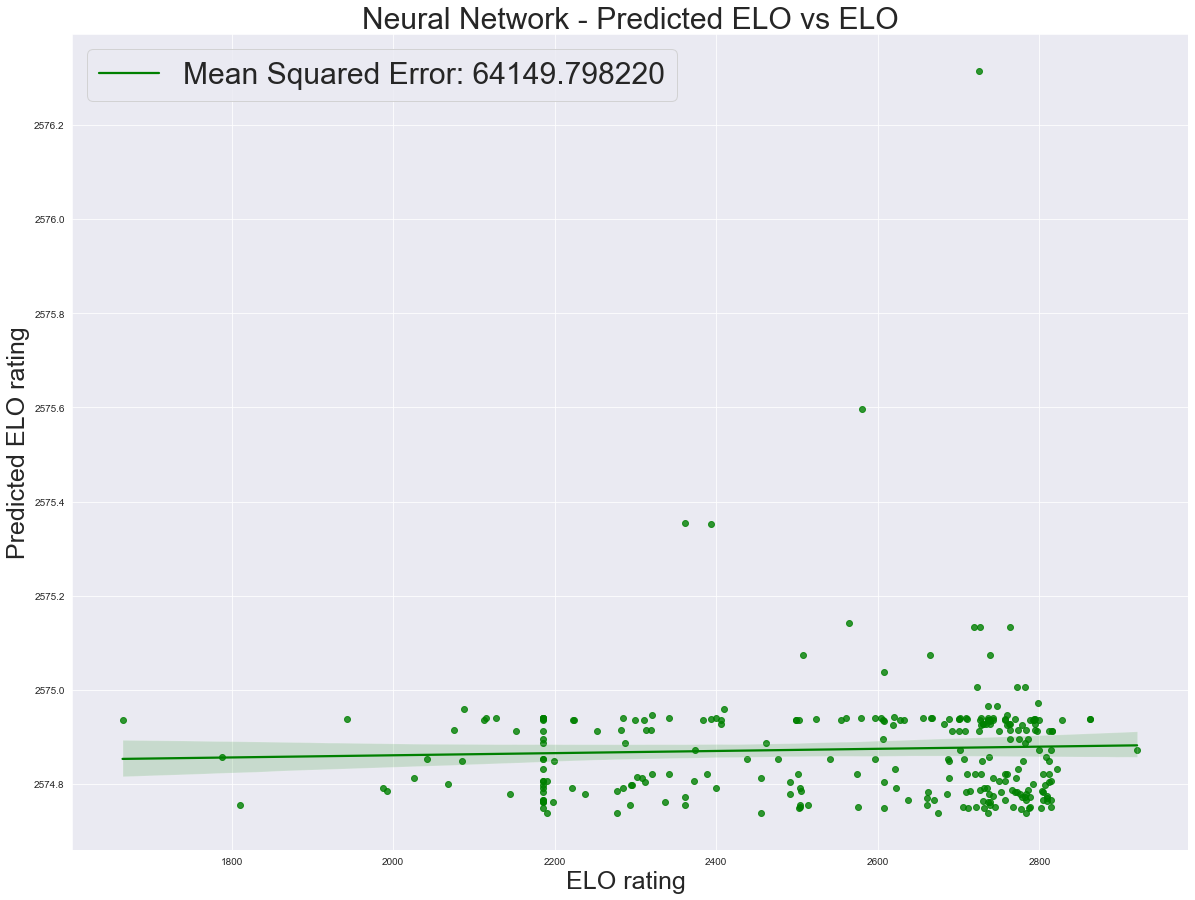

In [3409]:
plt.figure(figsize = (20,15))
plt.title('Neural Network - Predicted ELO vs ELO', fontsize = 30)
sns.regplot(x = elos, y = outputs, color ='green', line_kws = {'label':f'Mean Squared Error: {mse_model:4f}'})
plt.xlabel('ELO rating ', fontsize = 25)
plt.ylabel('Predicted ELO rating', fontsize = 25)
plt.legend(prop={'size': 30})
plt.savefig('images/NN_model_acc1.png')

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

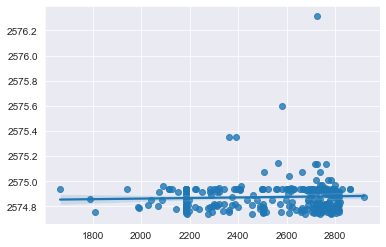

In [3410]:
sns.regplot(elos,outputs)

# Plotting the neural net architecture

In [3411]:
print(max(outputs))
print(min(outputs))

[2576.31340728]
[2574.73912835]


In [3412]:
# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
#traced_script_module = torch.jit.trace(model, example)

In [3413]:
params =dict(model.named_parameters())

In [3414]:
dot = make_dot(output, params=params, show_attrs=False, show_saved=False)

In [3415]:
#dot.render("rnn_torchviz3", format="pdf", engine= 'neato') # doesn't seem to work great with padded & packed input...